<a href="https://colab.research.google.com/github/kjamison/krakencoder/blob/main/krakencoder_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Krakencoder usage example**

This notebook provides an example of how to load connectome data and apply a pretrained Krakencoder model to that data.

The process is as follows:
1.   Load model
2.   Load new data and do mild domain adaptation (map input data mean to training data mean)
3.   Transform each input data flavor into 128-dimensional latent space
4.   Average latent space across all types ("fusion")
  * Note: this might be used for prediction, clustering, etc.
5.   Transform "fusion" averaged latent vectors to output connectomes



In [1]:
#clone repo and add to path
!git clone https://github.com/kjamison/krakencoder.git
import sys
if not '/content/krakencoder' in sys.path:
  sys.path.append('/content/krakencoder')

Cloning into 'krakencoder'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 360 (delta 42), reused 61 (delta 23), pack-reused 276
Receiving objects: 100% (360/360), 15.60 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [2]:
import torch
import numpy as np
from krakencoder.model import Krakencoder
from krakencoder.adaptermodel import KrakenAdapter
from krakencoder.utils import square2tri, tri2square, numpyvar
from krakencoder.data import generate_adapt_transformer, load_transformers_from_file
from krakencoder.fetch import fetch_model_data
from scipy.io import loadmat, savemat
import os
import humanize

In [3]:
# load model checkpoint and precomputed PCA transforms
# The first time these are used, they are downloaded to package_dir/model_data (~1.3GB)
# To use an alternate storage location, you can set the KRAKENCODER_DATA environment variable
checkpoint_file=fetch_model_data('kraken_chkpt_SCFC_fs86+shen268+coco439_pc256_225paths_latent128_20240413_ep002000.pt')

ioxfm_file_list=fetch_model_data(['kraken_ioxfm_SCFC_fs86_pc256_710train.npy',
                 'kraken_ioxfm_SCFC_shen268_pc256_710train.npy',
                 'kraken_ioxfm_SCFC_coco439_pc256_710train.npy'])

inner_net, checkpoint_info = Krakencoder.load_checkpoint(checkpoint_file, eval_mode=True)
transformer_list, transformer_info_list = load_transformers_from_file(ioxfm_file_list)

#create new model that wraps the inner kraken model and includes PCA transforms from raw data
net=KrakenAdapter(inner_model=inner_net,
                  data_transformer_list=[transformer_list[conntype] for conntype in checkpoint_info['input_name_list']],
                  linear_polynomial_order=0,
                  eval_mode=True)

100%|██████████| 4.07M/4.07M [00:00<00:00, 14.1MB/s]


100%|██████████| 37.6M/37.6M [00:02<00:00, 17.1MB/s]


100%|██████████| 368M/368M [00:13<00:00, 27.7MB/s]


100%|██████████| 988M/988M [00:13<00:00, 70.9MB/s]


Loading precomputed input transformations: /content/cache/krakencoder/model_data/kraken_ioxfm_SCFC_fs86_pc256_710train.npy
Loading precomputed input transformations: /content/cache/krakencoder/model_data/kraken_ioxfm_SCFC_shen268_pc256_710train.npy
Loading precomputed input transformations: /content/cache/krakencoder/model_data/kraken_ioxfm_SCFC_coco439_pc256_710train.npy


In [4]:
#load example data (10 validation subjects from HCP-YA)
conndata_squaremats=loadmat('krakencoder/example_data/exampledata_10subj_fs86_inputs.mat',simplify_cells=True)

#skip internal header keys
conntypes=[c for c in conndata_squaremats.keys() if not c.startswith("_")]

#input data are lists of [roi x roi] square matrices so convert those to [subj x edges]
conndata={}
conndata_triidx={} #store so we can restore square later
for c in conntypes:
  conndata[c]={'data': np.stack([square2tri(x) for x in conndata_squaremats[c]['data']])}
  _, conndata_triidx[c]=square2tri(conndata_squaremats[c]['data'][0],return_indices=True)
  print("conndata_squaremats['%s']['data']" % (c),conndata_squaremats[c]['data'].shape, conndata_squaremats[c]['data'][0].shape)
  print(" -> conndata['%s']['data']" % (c),conndata[c]['data'].shape)
del conndata_squaremats

conndata_squaremats['SCifod2act_fs86_volnorm']['data'] (10,) (86, 86)
 -> conndata['SCifod2act_fs86_volnorm']['data'] (10, 3655)
conndata_squaremats['SCsdstream_fs86_volnorm']['data'] (10,) (86, 86)
 -> conndata['SCsdstream_fs86_volnorm']['data'] (10, 3655)
conndata_squaremats['FCcorr_fs86_hpf']['data'] (10,) (86, 86)
 -> conndata['FCcorr_fs86_hpf']['data'] (10, 3655)
conndata_squaremats['FCcorr_fs86_hpfgsr']['data'] (10,) (86, 86)
 -> conndata['FCcorr_fs86_hpfgsr']['data'] (10, 3655)
conndata_squaremats['FCpcorr_fs86_hpf']['data'] (10,) (86, 86)
 -> conndata['FCpcorr_fs86_hpf']['data'] (10, 3655)


In [5]:
# compute SIMPLE domain adaptation transform: map mean(input subjects) to mean(training subjects) for each flavor
# and transform each input data flavor to match training data mean
#
# It's not really needed for these data since they are from HCP-YA already, which the model was trained on.
# That is why the model fits are all roughly "y = 1.0*x + 0". It is shown here for demonstration purposes only.
adxfm_dict={}
conndata_adapted={}
for c in conndata:
  adxfm_dict[c]=generate_adapt_transformer(input_data=conndata[c]['data'],
                                           target_data=transformer_info_list[c],
                                           adapt_mode='meanfit+meanshift')
  conndata_adapted[c]={'data':adxfm_dict[c].transform(conndata[c]['data'])}

	Fitting input data mean to transformer mean: modeldata=inputdata*0.992 + -0.000
	Fitting input data mean to transformer mean: modeldata=inputdata*1.008 + 0.000
	Fitting input data mean to transformer mean: modeldata=inputdata*0.936 + 0.008
	Fitting input data mean to transformer mean: modeldata=inputdata*0.935 + -0.001
	Fitting input data mean to transformer mean: modeldata=inputdata*0.932 + 0.001


In [6]:
# transform input data to krakencoder latent space
encoded_data={}

#loop through all of the input names from the saved checkpoint,
# because the encoder/decoder indices are in this order.
for encidx, c in enumerate(checkpoint_info['input_name_list']):
  if not c in conndata_adapted:
    #if this input type was not in the example data, skip it
    continue
  encoded_data[c]=net(conndata_adapted[c]['data'],encoder_index=encidx, decoder_index=-1)

# compute average latent representation
encoded_fusion=torch.mean(torch.stack([encoded_data[c] for c in encoded_data]),axis=0)

print("fusion latent space representation: ", encoded_fusion.shape)

# Now predict output connectomes from fusion latent representation
# Predictions are stored in predicted_alltypes[inputtype][outputtype]
predicted_alltypes={'fusion':{}}

for decidx, c in enumerate(checkpoint_info['input_name_list']):
    _,pred=net(encoded_fusion,encoder_index=-1, decoder_index=decidx)
    predicted_alltypes['fusion'][c]=numpyvar(pred) #convert back to numpy for analysis
    print("predicted_alltypes['fusion']['%s']: " % (c), predicted_alltypes['fusion'][c].shape)

#add fusion latent representation to output
predicted_alltypes['fusion']['encoded']=numpyvar(encoded_fusion)
print("predicted_alltypes['fusion']['%s']: " % ('encoded'), predicted_alltypes['fusion']['encoded'].shape)


fusion latent space representation:  torch.Size([10, 128])
predicted_alltypes['fusion']['SCifod2act_fs86_volnorm']:  (10, 3655)
predicted_alltypes['fusion']['SCsdstream_fs86_volnorm']:  (10, 3655)
predicted_alltypes['fusion']['FCcorr_fs86_hpf']:  (10, 3655)
predicted_alltypes['fusion']['FCcorr_fs86_hpfgsr']:  (10, 3655)
predicted_alltypes['fusion']['FCpcorr_fs86_hpf']:  (10, 3655)
predicted_alltypes['fusion']['SCifod2act_shen268_volnorm']:  (10, 35778)
predicted_alltypes['fusion']['SCsdstream_shen268_volnorm']:  (10, 35778)
predicted_alltypes['fusion']['FCcorr_shen268_hpf']:  (10, 35778)
predicted_alltypes['fusion']['FCcorr_shen268_hpfgsr']:  (10, 35778)
predicted_alltypes['fusion']['FCpcorr_shen268_hpf']:  (10, 35778)
predicted_alltypes['fusion']['SCifod2act_coco439_volnorm']:  (10, 96141)
predicted_alltypes['fusion']['SCsdstream_coco439_volnorm']:  (10, 96141)
predicted_alltypes['fusion']['FCcorr_coco439_hpf']:  (10, 96141)
predicted_alltypes['fusion']['FCcorr_coco439_hpfgsr']:  (10,

In [7]:
# save outputs to file for later analysis
outfile='exampledata_outputs.mat'
savemat(outfile, {'predicted_alltypes':predicted_alltypes}, format='5',do_compression=True)
print("Saved %s (%s)" % (outfile, humanize.naturalsize(os.path.getsize(outfile))))

Saved exampledata_outputs.mat (23.1 MB)


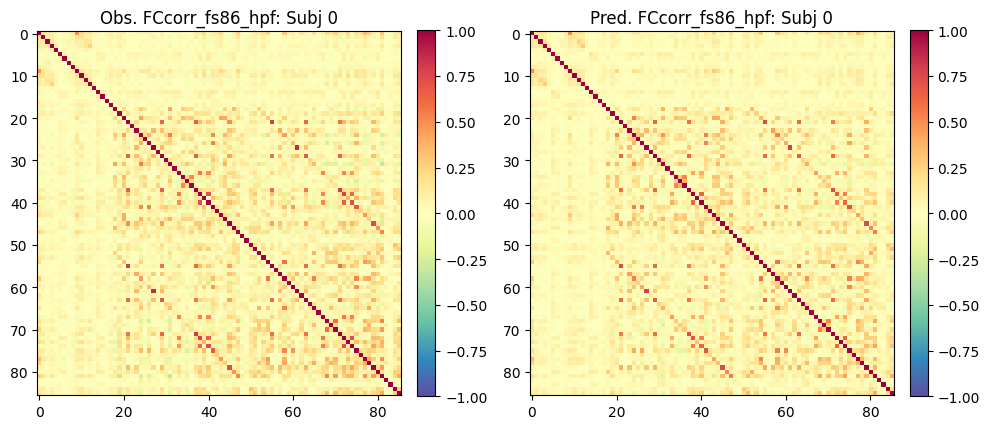

In [8]:
# convert upper tri back to square to display observed and predicted connectomes

import matplotlib.pyplot as plt

conntype='FCcorr_fs86_hpf'
isubj=0

Cobs_square=tri2square(conndata_adapted[conntype]['data'][isubj,:],
                            tri_indices=conndata_triidx[conntype],
                            diagval=1) #diagval=1 for FC
Cpred_square=tri2square(predicted_alltypes['fusion'][conntype][isubj,:],
                            tri_indices=conndata_triidx[conntype],
                            diagval=1) #diagval=1 for FC

#make sure these are converted back to CPU/numpy before trying to display
Cobs_square=numpyvar(Cobs_square)
Cpred_square=numpyvar(Cpred_square)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
im=plt.imshow(Cobs_square, vmin=-1, vmax=1, cmap='Spectral_r')
plt.colorbar(im,fraction=0.046, pad=.04)
plt.title('Obs. %s: Subj %d' % (conntype,isubj))

plt.subplot(1,2,2)
im=plt.imshow(Cpred_square, vmin=-1, vmax=1, cmap='Spectral_r')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Pred. %s: Subj %d' % (conntype,isubj))

plt.tight_layout()
plt.show()